# Comparison of NDTI and NDSSI

Jason MacDonald  
UW Geospatial Data Analysis  
CEE467/CEWA567  
credit to: David Shean  

## Access images

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

In [2]:
import rasterio as rio
import rasterio.windows
import rasterio.plot
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [3]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#for titles
from textwrap import wrap

In [4]:
!pip install earthaccess

In [5]:
#May want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
#%matplotlib inline

In [6]:
pwd

'/home/jovyan/project/chelanigans'

In [7]:
#Set up directory for output
notebook = 'chelan_3_ndti-ndssi'
path = '/home/jovyan/project/chelanigans/output/%s' %notebook
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [8]:
path = '/home/jovyan/project/chelanigans/output/chelan_0_query-data_2021/gf_lesscloud_20_sentinel.geoJSON'
gf_lesscloud_20_sentinel = gpd.read_file(path)
gf_lesscloud_20_sentinel_lt = gf_lesscloud_20_sentinel.drop(columns=['start_datetime', 'end_datetime', 'mgrs', 'geometry'])
gf_lesscloud_20_sentinel_lt

,eo:cloud_cover,datetime,stac_id,time,platform
0,5,2021-03-03 19:11:08.571000+00:00,HLS.S30.T10UFU.2021062T190301.v2.0,2021-03-03 19:11:08.571000+00:00,S
1,16,2021-04-02 19:11:05.535000+00:00,HLS.S30.T10UFU.2021092T185921.v2.0,2021-04-02 19:11:05.535000+00:00,S
2,0,2021-04-17 19:11:04.007000+00:00,HLS.S30.T10UFU.2021107T185909.v2.0,2021-04-17 19:11:04.007000+00:00,S
3,9,2021-05-22 19:11:09.221000+00:00,HLS.S30.T10UFU.2021142T185921.v2.0,2021-05-22 19:11:09.221000+00:00,S
4,0,2021-06-01 19:11:09.530000+00:00,HLS.S30.T10UFU.2021152T185921.v2.0,2021-06-01 19:11:09.530000+00:00,S
5,1,2021-06-21 19:11:09.531000+00:00,HLS.S30.T10UFU.2021172T185921.v2.0,2021-06-21 19:11:09.531000+00:00,S
6,0,2021-06-26 19:11:09.416000+00:00,HLS.S30.T10UFU.2021177T185919.v2.0,2021-06-26 19:11:09.416000+00:00,S
7,4,2021-07-06 19:11:10.358000+00:00,HLS.S30.T10UFU.2021187T185919.v2.0,2021-07-06 19:11:10.358000+00:00,S
8,1,2021-07-11 19:11:11.712000+00:00,HLS.S30.T10UFU.2021192T185921.v2.0,2021-07-11 19:11:11.712000+00:00,S
9,10,2021-07-26 19:11:10.637000+00:00,HLS.S30.T10UFU.2021207T185919.v2.0,2021-07-26 19:11:10.637000+00:00,S


In [9]:
#for use with looping through rasters later
gdf = gf_lesscloud_20_sentinel
#gdf.iterrows(gdf['time'].date)
#for a in gdf.iterrows():
date = gdf.time.items()
img = gdf.stac_id.items()
date_img = zip(date, img)   
for d, img in date_img:
    date = d[1].date()
    print(date, img[1])

2021-03-03 HLS.S30.T10UFU.2021062T190301.v2.0
2021-04-02 HLS.S30.T10UFU.2021092T185921.v2.0
2021-04-17 HLS.S30.T10UFU.2021107T185909.v2.0
2021-05-22 HLS.S30.T10UFU.2021142T185921.v2.0
2021-06-01 HLS.S30.T10UFU.2021152T185921.v2.0
2021-06-21 HLS.S30.T10UFU.2021172T185921.v2.0
2021-06-26 HLS.S30.T10UFU.2021177T185919.v2.0
2021-07-06 HLS.S30.T10UFU.2021187T185919.v2.0
2021-07-11 HLS.S30.T10UFU.2021192T185921.v2.0
2021-07-26 HLS.S30.T10UFU.2021207T185919.v2.0
2021-09-24 HLS.S30.T10UFU.2021267T190029.v2.0


In [10]:
#Set path to local directory with downloaded images

imgdir = '/home/jovyan/project/chelanigans/data_sample'

In [312]:
## Pre-identified cloud-free Image IDs used for the lab
# PNW 2021 heatwave June 26 - July 2

i = 10
date = gdf.time[i].date()
img = gdf.stac_id[i]
#pre-heatwave 

#date_1 = 'April 17, 2021'  #SENTINEL
#img_id1 = 'HLS.S30.T10UFU.2021107T185909.v2.0'
#date_1 = 'April 20, 2021' 
#img_id1 = 'HLS.L30.T10UFU.2021110T185454.v2.0' #landsat
#date_1 = 'May 22, 2021'
#img_id1 = 'HLS.S30.T10UFU.2021142T185921.v2.0'
#date_1 = 'June 1, 2021'                      #no good
#img_id1 = 'HLS.S30.T10UFU.2021152T185921.v2.0'

#post-heatwave 

#date_2 = 'July 6, 2021'
#img_id2 = 'HLS.S30.T10UFU.2021187T185919.v2.0'
#date_2 = 'July 11, 2021'
#img_id2 = 'HLS.S30.T10UFU.2021192T185921.v2.0'
#date_2 = 'July 18, 2021'
#img_id2 = 'HLS.L30.T10UFU.2021199T184900.v2.0' #landsat
#date_2 = 'July 25, 2021' 
#img_id2 = 'HLS.L30.T10UFU.2021206T185515.v2.0' #landsat
#date_2 = 'September 24, 2021'
#img_id2 = 'HLS.S30.T10UFU.2021267T190029.v2.0'


#datetime = gf_lesscloud.datetime.iloc[0]
#date = datetime[0:10]
#date

KeyError: 11

In [313]:
#Define image to use (can set this to switch to pre/post heatwave image
#img = img_id1
#date = date_1

In [314]:
#Specify filenames for different bands

#Red
#r_fn = os.path.join(imgdir, img+'_SR_B4.TIF')
r_fn = os.path.join(imgdir, img+'.B04.tif')

#Green
#g_fn = os.path.join(imgdir, img+'_SR_B3.TIF')
g_fn = os.path.join(imgdir, img+'.B03.tif')

#Blue
#b_fn = os.path.join(imgdir, img+'_SR_B2.TIF')
b_fn = os.path.join(imgdir, img+'.B02.tif')

#Near-Infrared (NIR08)
#nir_fn = os.path.join(imgdir, img+'_SR_B5.TIF')
nir_fn = os.path.join(imgdir, img+'.B08.tif')

#Shortwave-Infrared (SWIR16)
#swir_fn = os.path.join(imgdir, img+'_SR_B6.TIF')
swir_fn = os.path.join(imgdir, img+'.B11.tif')

In [283]:
import earthaccess

auth = earthaccess.login(strategy="netrc")
if not auth:
    auth = earthaccess.login(strategy="interactive", persist=True)
# run single line below first time
#auth = earthaccess.login(strategy="interactive", persist=True)

We are already authenticated with NASA EDL


In [284]:
#Sentinel-2
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020'
#full_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021362T190811.v2.0/HLS.S30.T10UFU.2021362T190811.v2.0.B02.tif'

#landsat
#base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020'  
#full_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10UFU.2022001T185530.v2.0/HLS.L30.T10UFU.2022001T185530.v2.0.B02.tif'

#img_list = (img_id2, img_id1)
band_list = ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11') 

#Loop through all selected images and bands
#for img in img_list:
for d, img in date_img:
    #date = d[1].date()
    for b in band_list:
    #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1}/{1}.B{2}.tif'.format(base_url, img, b)    
        print(image_url)
    #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
    #Check to see if file already exists
    if not os.path.exists(out_fn):
        print("Saving:", out_fn)
        
        #Download the file
        #figure out authorization here
        #urllib.request.urlretrieve(image_url, out_fn)

In [285]:
#Sanity check
#Leave these Datasets open for use later in lab (e.g., extracting resolution)
r_src = rio.open(r_fn)
print("MS", r_src.profile)

MS {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 600000.0,
       0.0, -30.0, 5400000.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Note the width and height values for 15 m Pan band - these are different than the 30 m products for the same image

## Part 5: Raster window extraction

## Rasterio window
* Instead of array indexing, we can use the built-in `rasterio.windows.Window` functionality
    * This is really valuable when you only want to load a small portion of a large dataset that is too big to fit into available RAM
        * With array indexing, we must load the entire array into memory and then extract the desired window
        * With the rasterio window, we never have to load the full array
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`
* Let's define 1024x1024 px windows around Mt. Rainer and Seattle

In [286]:


#These are windows for Pan band, need to scale for others

#Lake Chelan
#window = rasterio.windows.Window(1750, 1000, 2048, 2048)
window = rasterio.windows.Window(2400, 1500, 512, 1024)
#window = rasterio.windows.Window(2250, 1500, 512, 512)

In [287]:
#NOTE: replaced p_src (opened pancromatic band file) with r_src (red) for the bounds input below
# no pan with Sentinel
# not sure if this is the best solution

#Define window bounds for Pan 
window_bounds = rasterio.windows.bounds(window, r_src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (672000.0, 5324280.0, 687360.0, 5355000.0)
Window extent:  [672000.0, 687360.0, 5324280.0, 5355000.0]


### Define a function to read only this subwindow into an array
* I provided sample code here, but please review so you understand each step

In [288]:
def rio2ma(fn, b=1, window=None, scale=True):
    with rio.open(fn) as src:
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        #If Level 2 surface reflectance and surface temperature, scale values appropriately
        #not needed for this project
        if scale:
            if 'SR' in fn:
                #Output in unitless surface reflectance from 0-1
                a = a * sr_scale + sr_offset
            elif 'ST' in fn:
                #Output in degrees Celsius
                a = a * st_scale + st_offset - 273.15
            a = a.astype('float32')
        return a

## Part 6: Contrast Enhancement
### Create a quick histogram for the window array
* This will help you visualize the range of DN values
* Remember to use the numpy masked array `compressed()` function to remove the nodata values before generating your histogram, and use enough bins to capture the true distribution without aliasing

In [289]:
#fig, ax = plt.subplots()

#ax.hist(mr_pan.compressed().ravel(), bins=256, color='violet', log=False)

#ax.set_ylabel('Number of occurences')
#ax.set_xlabel('DN values')
#ax.set_title('Histogram of DN values within Mt. Rainier window');

### Function to normalize (AKA contrast stretch) input image array values
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to rescale to `float` values over the range (0.0-1.0)
    * Let's use the simple rescaling "min-max normalization" here: https://en.wikipedia.org/wiki/Feature_scaling
* So we need a function to remap the DN values from 0-65535 to 0-1
    * A robust contrast enhancement is to use the 2nd and 98th percentile DN values as the min and max values for the rescaling step:
        * The DN value of the 2nd percentile should map to 0
        * The DN value at the 98th percentile should map to 1
        * Note that we will now have some values less than 0 and some values greater than 1 in the output!
            * Optional - add a step to "clip" the remapped values, so that any values less than 0 are set to 0, and any values greater than 1 are set to 1
                * See https://numpy.org/doc/stable/reference/generated/numpy.ma.clip.html
* Your function should return a new array (with `float` dtype) and values distributed over the (0.0-1.0) range
* Take some time to think this through, discuss with others, and sanity check your output

In [290]:
def normie(data, low_perc, up_perc):
    perc = np.percentile(data.compressed(), (low_perc, up_perc)) #default (2, 98)
    normd = (data - perc[0])/(perc[1] - perc[0])
    clipd = np.clip(normd, 0, 1)
    return clipd

## Part 7: Composite images
* http://gsp.humboldt.edu/olm/Courses/GSP_216/lessons/composites.html

### Create a natural "true-color" RGB (red, green, blue) composite for this window
* This represents "true" color, closer to what your eye would see
* Use the `rio2ma` function to load the same window from the red, green and blue band tif files
    * ⚠️ Make sure you pass in the window, and don't try to load the full images here!  Can potentially fill RAM on your Jupyterhub server, leading to kernel restart!
* Then normalize each channel independently using your `norm` function
    * Note: the surface reflectance values for Bands 1-7 (visible and near-IR) should already be scaled from 0.0-1.0 due to scaling in the original `rio2ma` function at the beginning of the notebook
    * This additional normalization step will stretch using the 2-98% values, giving you improved contrast for actual distribution of values
* Use numpy `dstack` to combine as a 3D array
    * https://numpy.org/doc/stable/reference/generated/numpy.dstack.html
    * Be careful of the band order here!
    * Sanity check: final array shape should be (1024, 1024, 3)

In [291]:
# load window from red, green, blue tif files
r = rio2ma(r_fn, b=1, window=window, scale=True)
g = rio2ma(g_fn, b=1, window=window, scale=True)
b = rio2ma(b_fn, b=1, window=window, scale=True)
nir = rio2ma(nir_fn, b=1, window=window, scale=True)
swir = rio2ma(swir_fn, window=window, scale=True)

r_norm = normie(r, 2, 98)
g_norm = normie(g, 2, 98)
b_norm = normie(b, 2, 98)
nir_norm = normie(nir, 2, 98)
swir_norm = normie(swir, 2, 98)

#r_norm = normie(r, 0.1, 25)
#g_norm = normie(g, 0.1, 25)
#b_norm = normie(b, 0.1, 25)

fin = np.dstack((r_norm,g_norm,b_norm))
fin.shape

(1024, 512, 3)

### Plot the natural color composite
* Pass the 3-band array to `imshow`
    * Because this is such a common image format (just think about all of the RGB photos of cats on the web), `imshow` can recognize this as a 3-band array and plot, assuming values are red, green, and blue channels!
    * See doc here for (M, N, 3) array input: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
* Pass the relevant `extent` to imshow so your coordinate axes labels are meteres in projected CRS
* Add a scalebar
* Things should start to look more normal:
    * Trees should appear dark green
    * Snow: white
    * Exposed glacier ice: light blue
    * Exposed rock (or debris-covered ice): brown

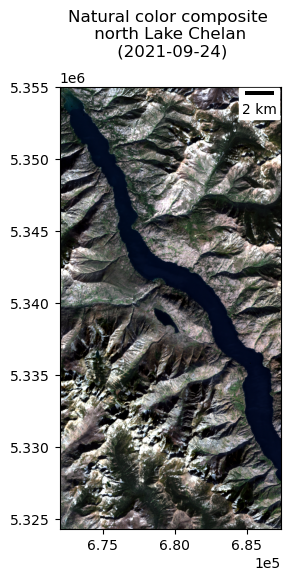

In [292]:
fig, ax = plt.subplots(figsize=(3,6))

#ax.imshow(fin, cmap='gray', extent=window_extent)
ax.imshow(fin, extent=window_extent)

ax.add_artist(ScaleBar(1.0))
ax.ticklabel_format(scilimits=(1,3))
ax.set_title(('Natural color composite \n north Lake Chelan \n (%s)' %date), y=1.05)
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/natural-color-comp_%s.png' %(notebook, date))
if os.path.isfile(strFile):
    #os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

## Let's try to make the water (dark colors) pop

First, we must isolate the water from the land..

In [293]:
#nir = rio2ma(nir_fn, b=1, window=window, scale=True)
#g = rio2ma(g_fn, b=1, window=window, scale=True)
ndwi = (g - nir) / (g + nir)
ndwi = np.ma.clip(ndwi, -1, 1)

In [294]:
water_threshold = 0.1

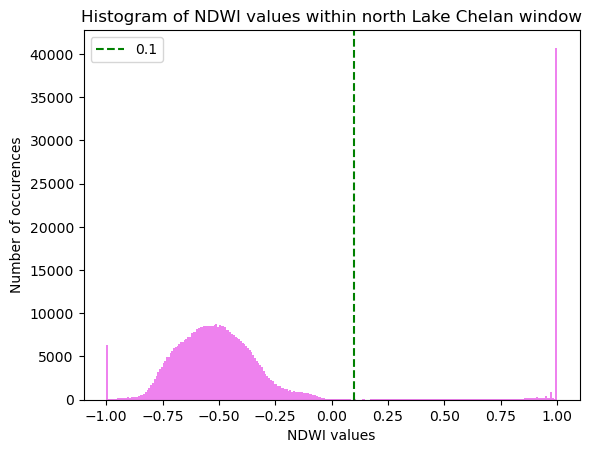

In [295]:
fig, ax = plt.subplots()

ax.hist(ndwi.compressed().ravel(), bins=256, color='violet', log=False)

ax.axvline(water_threshold, ls='--', c='g', label=water_threshold)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('NDWI values')
ax.set_title('Histogram of NDWI values within north Lake Chelan window');

In [296]:
import matplotlib.patches as mpatches #for legend

In [297]:
ndwi_chelan = np.ma.masked_less(ndwi, water_threshold)

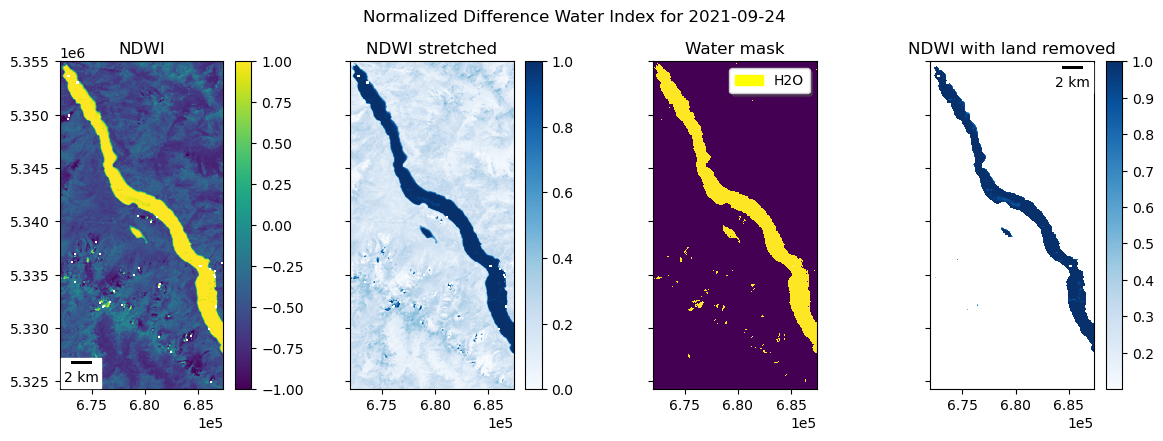

In [298]:
fig, axa = plt.subplots(1, 4, figsize=(12,4.5), sharex=True, sharey=True)

ndwi_mask = ndwi>= water_threshold

shw0 = axa[0].imshow(ndwi, cmap='viridis', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDWI')
axa[0].ticklabel_format(scilimits=(1,3))

ndwi_norm = normie(ndwi, 2, 98)
shw1 = axa[1].imshow(ndwi_norm, cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw1)
axa[1].set_title('NDWI stretched')
axa[1].ticklabel_format(scilimits=(1,3))

shw2 = axa[2].imshow(ndwi_mask, extent=window_extent, interpolation='none')
axa[2].set_title('Water mask')
axa[2].ticklabel_format(scilimits=(1,3))

shw3 = axa[3].imshow(ndwi_chelan, cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw3)
axa[3].add_artist(ScaleBar(1.0, location='upper right'))
axa[3].set_title('NDWI with land removed')
axa[3].ticklabel_format(scilimits=(1,3))

veg_legend = mpatches.Patch(color='yellow', label='H2O')
axa[2].legend(handles=[veg_legend], loc='upper right', shadow=True, fancybox=True)
#https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

fig.suptitle('Normalized Difference Water Index for %s' %date, y=0.97)
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/ndwi_%s.png' %(notebook, date))
if os.path.isfile(strFile):
    #os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

### the url below needs work

In [299]:
#wa_lakes_gjson_url = '#https://geo.wa.gov/datasets/WSDOT::wsdot-major-lakes-1500k/explore?filters=eyJOQU1FIjpbIkxha2UgQ2hlbGFuIl19&location=48.085597%2C-120.767080%2C9.89'
wa_lakes_gjson_url = '/home/jovyan/project/chelanigans/data_sample/WSDOT_-_Major_Lakes_(1%3A500K).geojson'
wa_lakes_gjson_gdf = gpd.read_file(wa_lakes_gjson_url) #just pointing to downloaded file for now
#Reproject to match raster
wa_lakes_gjson_gdf_proj = wa_lakes_gjson_gdf.to_crs(r_src.crs)
#Isolate WA state
chelan_gjson_iso = wa_lakes_gjson_gdf_proj.loc[wa_lakes_gjson_gdf_proj['NAME'] == 'Lake Chelan']
#Extract geometry to use for clipping
chelan_geom = chelan_gjson_iso.iloc[0].geometry

In [300]:
#Pass this in to the `rio.mask.mask` call (see demo)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
#must pass chelan_geom polygon as list because rio.mask.mask expects multipolygon
chelan_mask, chelan_mask_transform = rio.mask.mask(r_src, [chelan_geom,], **rio_mask_kwargs)

In [301]:
#Get clipped extent in UTM coordinates
chelan_mask_extent = rio.plot.plotting_extent(chelan_mask, chelan_mask_transform)
chelan_mask_extent

(672150.0, 709800.0, 5302170.0, 5354820.0)

In [302]:
#set our index variables for 
#normalized difference turbidity index
#normalized difference suspended solids index

ndti = (r - g) / (r + g)
ndssi = (b - nir) / (b + nir)

In [303]:
ndti = np.ma.clip(ndti, -1, 0)
ndssi = np.ma.clip(ndssi, -1, 0)

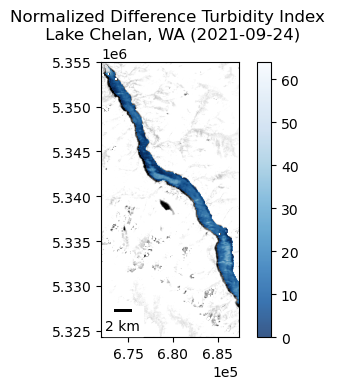

In [304]:
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(ndti, extent=window_extent, cmap='gray')
m = ax.imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=64)

ax.add_artist(ScaleBar(1.0, location='lower left'))
ax.ticklabel_format(scilimits=(1,3))
ax.set_xlim(window_extent[0], window_extent[1])
ax.set_ylim(window_extent[2], window_extent[3])

ax.set_title(('Normalized Difference Turbidity Index \n Lake Chelan, WA (%s)' %date))

fig.colorbar(m, ax=ax)
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/ndti_%s.png' %(notebook, date))
if os.path.isfile(strFile):
    #os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

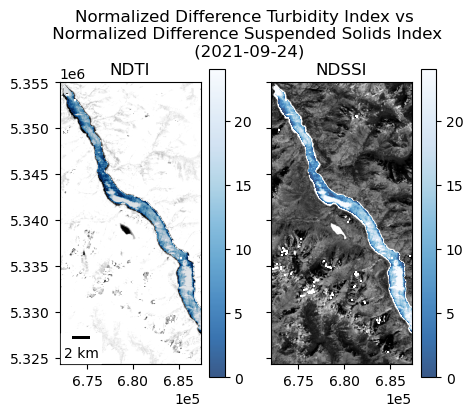

In [305]:
fig, axa = plt.subplots(1, 2, figsize=(5,4), sharex=True, sharey=True)

axa[0].imshow(ndti, extent=window_extent, cmap='gray')
shw0 = axa[0].imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDTI')
axa[0].ticklabel_format(scilimits=(1,3))
axa[0].set_xlim(window_extent[0], window_extent[1])
axa[0].set_ylim(window_extent[2], window_extent[3])

axa[1].imshow(normie(ndssi, 2, 98), extent=window_extent, cmap='gray')
shw0 = axa[1].imshow(chelan_mask, cmap='Blues_r', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=24)
bar = plt.colorbar(shw0)
axa[1].set_title('NDSSI')
axa[1].ticklabel_format(scilimits=(1,3))
axa[1].set_xlim(window_extent[0], window_extent[1])
axa[1].set_ylim(window_extent[2], window_extent[3])

fig.suptitle(('Normalized Difference Turbidity Index vs \n Normalized Difference Suspended Solids Index \n (%s)' %date),
             y=1.03)
#plt.tight_layout()
strFile = ('/home/jovyan/project/chelanigans/output/%s/ndti-vs-ndssi_%s.png' %(notebook, date))
if os.path.isfile(strFile):
    #os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

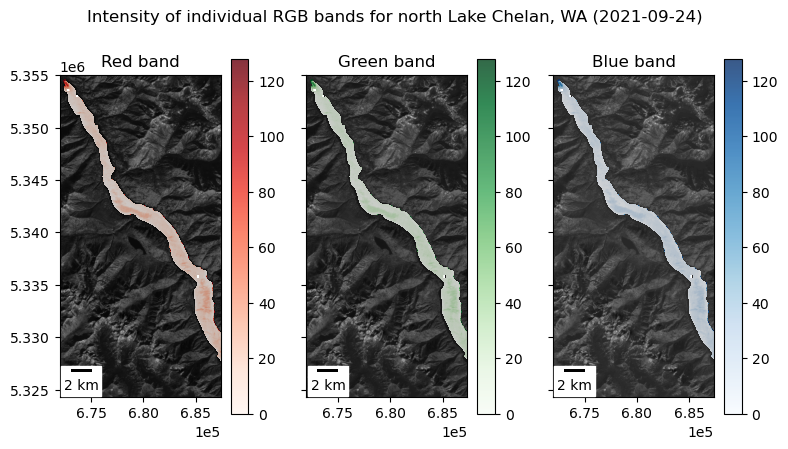

In [306]:
fig, axa = plt.subplots(1, 3, figsize=(8,4.35), sharex=True, sharey=True)

axa[0].imshow(r, extent=window_extent, cmap='gray')
shw0 = axa[0].imshow(chelan_mask, cmap='Reds', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=128)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('Red band')
axa[0].ticklabel_format(scilimits=(1,3))
axa[0].set_xlim(window_extent[0], window_extent[1])
axa[0].set_ylim(window_extent[2], window_extent[3])

axa[1].imshow(g, extent=window_extent, cmap='gray')
shw1 = axa[1].imshow(chelan_mask, cmap='Greens', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=128)
bar = plt.colorbar(shw1)
axa[1].add_artist(ScaleBar(1.0, location='lower left'))
axa[1].set_title('Green band')
axa[1].ticklabel_format(scilimits=(1,3))
axa[1].set_xlim(window_extent[0], window_extent[1])
axa[1].set_ylim(window_extent[2], window_extent[3])

axa[2].imshow(b, extent=window_extent, cmap='gray')
shw2 = axa[2].imshow(chelan_mask, cmap='Blues', extent=chelan_mask_extent, alpha=0.8, vmin=0, vmax=128)
bar = plt.colorbar(shw2)
axa[2].add_artist(ScaleBar(1.0, location='lower left'))
axa[2].set_title('Blue band')
axa[2].ticklabel_format(scilimits=(1,3))
axa[2].set_xlim(window_extent[0], window_extent[1])
axa[2].set_ylim(window_extent[2], window_extent[3])

fig.suptitle(('Intensity of individual RGB bands for north Lake Chelan, WA (%s)' %date),
             y=1.01)
plt.tight_layout()

strFile = ('/home/jovyan/project/chelanigans/output/%s/rgb_masked_%s.png' %(notebook, date))
if os.path.isfile(strFile):
    #os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);plt.show();

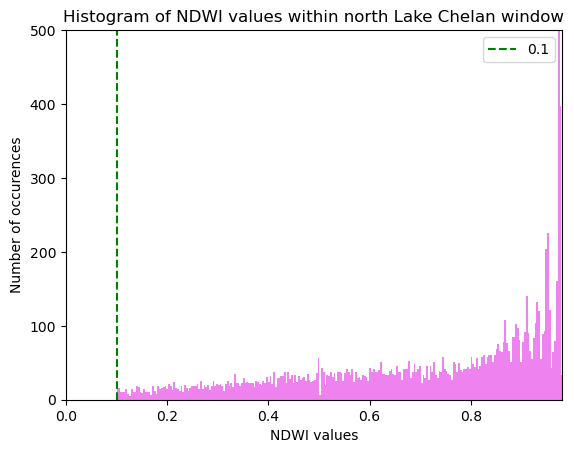

In [307]:
fig, ax = plt.subplots()

ax.hist(ndwi_chelan.compressed().ravel(), bins=256, color='violet', log=False)

ax.axvline(water_threshold, ls='--', c='g', label=water_threshold)

ax.set_xlim(0, 0.98)
ax.set_ylim(0, 500)

ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('NDWI values')
ax.set_title('Histogram of NDWI values within north Lake Chelan window');

In [308]:
import matplotlib.patches as mpatches #for legend

In [309]:
ndwi_chelan = np.ma.masked_less(ndwi, water_threshold)

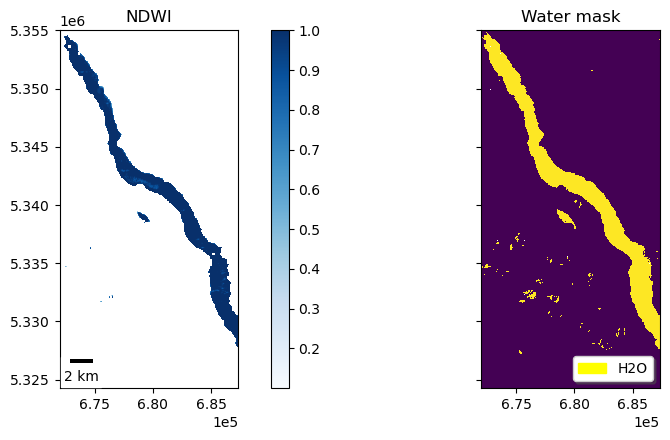

In [310]:

fig, axa = plt.subplots(1, 2, figsize=(12,4.5), sharex=True, sharey=True)

ndwi_mask = ndwi>= water_threshold

shw1 = axa[1].imshow(ndwi_mask, extent=window_extent, interpolation='none')
axa[1].set_title('Water mask')
axa[1].ticklabel_format(scilimits=(1,3))

shw0 = axa[0].imshow(ndwi_chelan, cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDWI')
axa[0].ticklabel_format(scilimits=(1,3))

veg_legend = mpatches.Patch(color='yellow', label='H2O')
axa[1].legend(handles=[veg_legend], loc='lower right', shadow=True, fancybox=True)
#https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

plt.tight_layout()
plt.show();

In [311]:
from ipywidgets import HBox, VBox, Label, Layout

#!pip install arcgis
import arcgis
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster.analytics import convert_feature_to_raster, convert_raster_to_feature
from arcgis.raster.functions import extract_band, greater_than, clip, remap, colormap, stretch
from arcgis.features.analysis import dissolve_boundaries

ModuleNotFoundError: No module named 'arcgis'

In [ ]:
def create_binary_poly(binaryras_lyr, timestamp):
    print('creating binary feature layer',end='\r')
    binary_poly = convert_raster_to_feature(binaryras_lyr, 
                                          field='Value', 
                                          output_type='Polygon', 
                                          simplify=True, 
                                          output_name='binary_poly'+timestamp, 
                                          gis=ent_gis)
    return binary_poly

In [ ]:
def extract_water_polygons(binary_poly, timestamp):
    print('extracting water polygon',end='\r')
    dfm=binary_poly.layers[0].query('gridcode=1').sdf 
    water_poly=gis_ent.content.import_data(dfm, title='wpoly'+timestamp)
    return water_poly

In [ ]:
bp = create_binary_poly(ndwi_mask, 'test')
water_poly = extract_water_polygons(bp, 'test')
water_poly

In [ ]:
coords = np.column_stack(np.where(ndwi_mask > 0))
coords

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

a = coords

polygons = [Polygon(a[i].reshape(-1,2)) for i in range(len(a))]

_,ax = plt.subplots()
ax.add_collection(PatchCollection(polygons,fc='none',ec='r'))
ax.set_xlim(0,512)
ax.set_ylim(0,1024);

In [ ]:
#shapes = rasterio.features.shapes(blue, mask=mask, transform=r_src.transform)
#shapes = rasterio.features.shapes(ndwi_mask, transform=r_src.transform)

shapes = rasterio.features.shapes(ndwi_mask, transform=r_src.transform)

In [ ]:
import numpy as np
from imantics import Polygons, Mask
ndwi_shape = ndwi_mask.polygons()

In [ ]:
#%matplotlib widget
%matplotlib inline

In [ ]:
fig, ax = plt.subplots()

red_threshold = 0.1

ax.hist(r.compressed().ravel(), bins=400, color='red', log=False)

ax.axvline(red_threshold, ls='--', c='k', label=red_threshold)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Red band values')
ax.set_title('Histogram of Red band values within NDWI mask of Lake Chelan');

In [ ]:
fig, ax = plt.subplots()

green_threshold = 0.1

ax.hist(g.compressed().ravel(), bins=256, color='green', log=False)

ax.axvline(green_threshold, ls='--', c='k', label=green_threshold)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Green band values')
ax.set_title('Histogram of Green band values within NDWI mask of Lake Chelan');

In [ ]:
fig, ax = plt.subplots()

blue_threshold = 0.1

ax.hist(b.compressed().ravel(), bins=256, color='blue', log=False)

ax.axvline(blue_threshold, ls='--', c='k', label=blue_threshold)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Blue band values')
ax.set_title('Histogram of Blue band values within NDWI mask of Lake Chelan');

In [ ]:
fig, ax = plt.subplots()

w = 0.1

ax.hist(fin.compressed().ravel(), bins=256, color='violet', log=False)

ax.axvline(w, ls='--', c='g', label=w)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('RGB composite values')
ax.set_title('Histogram of RGB composite values within north Lake Chelan window');

### Create a color-infrared (CIR) composite and plot
* Load the same window from the Near-IR band
* Look up the band combination required here and be careful with order passed to `dstack`
    * http://gsp.humboldt.edu/olm/Courses/GSP_216/lessons/composites.html
* Sanity check: vegetation should appear red
    * Deciduous (leafy) vegetation will appear bright red
    * Coniferous (evergreen) vegetation will appear darker red

## Part 8: Raster band math and index ratios
* Let's use some common band ratios to classify vegetation, snow and water for our window
* NOTE: if you're using `UInt16` masked arrays here, you will want to first convert each to `float`, as some addition/subtraction operations could result in values outside of 0-65536 (e.g., areas that are bright in all visible bands, like snow).
    * Can use `myarray.astype(float)` for this
    * If you don't do this, you will end up with "wrapping" artifacts

### NDVI (normalized difference vegetation index)
* Resources:
    * https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
    * https://eos.com/ndvi/
* Create a new array to store the computed NDVI from the bands you've already loaded
* This should be simple - basic raster band math using NumPy arrays
    * Compute the ratio using the original band values (not normalized values)
    * Optional: use `np.ma.clip` to limit the output values to the (-1, 1) range, https://numpy.org/doc/stable/reference/generated/numpy.ma.clip.html
        * Otherwise, explicitly set `vmin=-1, vmax=1` in the imshow calls
* Plot and inspect
    * Plot original ndvi
    * Plot contrast-stretched ndvi using your normalization function above
    * Do you see different NDVI values for dense conifer trees (most of the scene) vs. open meadows or recently logged plots dominated by grass and other deciduous plants?

In [ ]:
nir = rio2ma(nir_fn, b=1, window=window, scale=True)
r = rio2ma(r_fn, b=1, window=window, scale=True)

ndvi = (nir - r)/(nir + r)

In [ ]:
ndvi = np.ma.clip(ndvi, -1, 1)

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5))

shw0 = axa[0].imshow(ndvi, cmap='RdYlGn', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0))
axa[0].set_title('NDVI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(normie(ndvi, 2, 98), cmap='Greens', extent=window_extent)
bar = plt.colorbar(shw1)
axa[1].add_artist(ScaleBar(1.0))
axa[1].set_title('NDVI rescaled')
axa[1].ticklabel_format(scilimits=(1,3))

fig.suptitle('Normalized Difference Vegetation Index for %s' %date)
plt.show();

### NDSI (normalized difference snow index)
* There are multiple definitions of NDSI in the literature, but let's use this one (using SWIR, since we have it available with LS-8):
    * https://eos.com/ndsi/

In [ ]:
swir = rio2ma(swir_fn, b=1, window=window, scale=True)
g = rio2ma(g_fn, b=1, window=window, scale=True)

ndsi = (g - swir) / (g + swir)

In [ ]:
ndsi = np.ma.clip(ndsi, -1, 1)

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5))

shw0 = axa[0].imshow(ndsi, cmap='viridis', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0))
axa[0].set_title('NDSI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(normie(ndsi, 2, 98), cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw1)
axa[1].add_artist(ScaleBar(1.0))
axa[1].set_title('NDSI rescaled')
axa[1].ticklabel_format(scilimits=(1,3))

fig.suptitle('Normalized Difference Snow Index for %s' %date)
plt.show();

### NDWI (normalized difference water index)
* Again, multiple definitions for different sensors.  Let's use the formula for surface water bodies (not leaves):
    * https://en.wikipedia.org/wiki/Normalized_difference_water_index


In [ ]:
#nir = rio2ma(nir_fn, b=1, window=window, scale=True)
#g = rio2ma(g_fn, b=1, window=window, scale=True)
ndwi = (g - nir) / (g + nir)
ndwi = np.ma.clip(ndwi, -1, 1)

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5))

shw0 = axa[0].imshow(ndwi, cmap='viridis', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0))
axa[0].set_title('NDWI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(normie(ndwi, 2, 98), cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw1)
axa[1].add_artist(ScaleBar(1.0))
axa[1].set_title('NDWI stretched')
axa[1].ticklabel_format(scilimits=(1,3))

fig.suptitle('Normalized Difference Water Index for %s' %date)
plt.show();

### NDSSI (normalized difference suspended sediment index)
[11] Hossain et al


In [ ]:
#nir = rio2ma(nir_fn, b=1, window=window, scale=True)
#g = rio2ma(g_fn, b=1, window=window, scale=True)
ndssi = (b - nir) / (b + nir)

In [ ]:
ndssi = np.ma.clip(ndssi, -1, 1)

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5))

shw0 = axa[0].imshow(ndssi, cmap='viridis', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0))
axa[0].set_title('NDSSI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(normie(ndssi, 2, 98), cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw1)
axa[1].add_artist(ScaleBar(1.0))
axa[1].set_title('NDSSI stretched')
axa[1].ticklabel_format(scilimits=(1,3))

fig.suptitle('Normalized Difference Suspended Sediment Index for %s' %date, y=1.05)

plt.show();

### NDTI (normalized difference turbidity index)
[4] C. Baughman et al


In [ ]:
#%matplotlib widget
%matplotlib inline

In [ ]:
#nir = rio2ma(nir_fn, b=1, window=window, scale=True)
#g = rio2ma(g_fn, b=1, window=window, scale=True)
ndti = (r - g) / (r + g)

In [ ]:
ndti = np.ma.clip(ndti, -1, 1)

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5))

shw0 = axa[0].imshow(ndti, cmap='viridis', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0))
axa[0].set_title('NDTI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(normie(ndti, 2, 98), cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw1)
axa[1].add_artist(ScaleBar(1.0))
axa[1].set_title('NDTI stretched')
axa[1].ticklabel_format(scilimits=(1,3))

fig.suptitle('Normalized Difference Turbidity Index for %s' %date)
plt.show();

### Extra Credit: create a figure with linked RGB, CIR, NDVI, NDSI, and NDWI products
* Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit
    * Zoom in on some vegetation, snow near the summit, and surface water like Mowich Lake (https://goo.gl/maps/V6YFJQPcfrDi9UXH6)
* Note how the different indices change (see interactive values for cursor position on each subplot), which should hopefully provide better sense of what the different indices are showing

In [ ]:
fig, axa = plt.subplots(1, 5, figsize=(24,4), sharex=True, sharey=True)

axa[0].imshow(fin, cmap='gray', extent=window_extent)
axa[0].set_title('Natural Color Composite')
axa[0].ticklabel_format(scilimits=(1,3))
axa[0].add_artist(ScaleBar(1.0, location='lower left'))

axa[1].imshow(normie(ndsi, 2, 98), cmap='Blues', extent=window_extent)
axa[1].set_title('NDSI')
axa[1].ticklabel_format(scilimits=(1,3))

axa[2].imshow(normie(ndwi, 2, 98), cmap='Blues', extent=window_extent)
axa[2].set_title('NDWI')
axa[2].ticklabel_format(scilimits=(1,3))

axa[3].imshow(normie(ndssi, 2, 98), cmap='Blues', extent=window_extent)
axa[3].set_title('NDSSI') #Hossain et al
axa[3].ticklabel_format(scilimits=(1,3))

shw1 = axa[4].imshow(normie(ndti, 2, 98), cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw1)
axa[4].add_artist(ScaleBar(1.0))
axa[4].set_title('NDTI') #Baughman et al
axa[4].ticklabel_format(scilimits=(1,3))

fig.suptitle('Normalized Difference Indices for %s' %date, y=1.15)
fig.tight_layout(pad=-1.75)
plt.locator_params(axis='x', nbins=4)
plt.show();

# NOTE: not sure why but..
# nbins=1,2,3 gives 2 ticks,
# nbins=4,5,6 gives 3 ticks,
# nbins=7,8 gives 7 and 8 ticks as expected.
#https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks

## Part 9: Raster Classification Using Threshold
### Create a binary suspended solids mask
* Need to define a cutoff value (threshold) for NDVI values to define a boolean vegetation mask
    * NDVI values above this threshold will be classified as "vegetation"
    * NDVI values below this threshold will be classified as "not vegetation"
    * This might be a useful resource: https://eos.com/ndvi/
* To decide on a threshold, probably useful review your NDVI plot above and maybe create plot a histogram of NDVI values
* Output mask should be boolean (True/False)
    * Should be true (1) for vegetation pixels and false (0) for all other pixels
* Create a figure with two subplots to show the NDVI map and your corresponding vegetation mask

In [ ]:
w = 0.1

In [ ]:
fig, ax = plt.subplots()

ax.hist(ndwi.compressed().ravel(), bins=256, color='violet', log=False)

ax.axvline(w, ls='--', c='g', label=w)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('NDWI values')
ax.set_title('Histogram of NDWI values within north Lake Chelan window');

In [ ]:
import matplotlib.patches as mpatches #for legend

In [ ]:
ndwi_chelan = np.ma.masked_less(ndwi, w)

In [ ]:

fig, axa = plt.subplots(1, 2, figsize=(12,4.5), sharex=True, sharey=True)

ndwi_mask = ndwi>= w

shw1 = axa[1].imshow(ndwi_mask, extent=window_extent, interpolation='none')
axa[1].set_title('Water mask')
axa[1].ticklabel_format(scilimits=(1,3))

shw0 = axa[0].imshow(ndwi_chelan, cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDWI')
axa[0].ticklabel_format(scilimits=(1,3))



veg_legend = mpatches.Patch(color='yellow', label='H2O')
axa[1].legend(handles=[veg_legend], loc='lower right', shadow=True, fancybox=True)
#https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

plt.tight_layout()
plt.show();

In [ ]:
ndti_masked = np.ma.masked_where(ndwi_mask==1, ndti)

In [ ]:
plt.imshow(ndti_masked, vmin=-1, vmax=0);

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5), sharex=True, sharey=True)

ndwi_wat = ndwi>= w

shw0 = axa[0].imshow(ndwi_mask, cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDWI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(ndti_masked, extent=window_extent, interpolation='none')
bar = plt.colorbar(shw1)
axa[1].set_title('NDTI masked')
axa[1].ticklabel_format(scilimits=(1,3))

veg_legend = mpatches.Patch(color='purple', label='Turbidity')
axa[1].legend(handles=[veg_legend], loc='lower right', shadow=True, fancybox=True)
#https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

plt.tight_layout()
plt.show();

In [ ]:
import pandas as pd
from ipywidgets import HBox, VBox, Label, Layout


import arcgis
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster.analytics import convert_feature_to_raster, convert_raster_to_feature
from arcgis.raster.functions import extract_band, greater_than, clip, remap, colormap, stretch
from arcgis.features.analysis import dissolve_boundaries

In [ ]:
def create_binary_raster(ndwi_lyr, t):
    print('creating binary raster',end='\r')
    binary_raster = greater_than([ndwi_lyr, 0.03], 
                              extent_type='FirstOf', 
                              cellsize_type='FirstOf', 
                              astype='U16')
    binary_ras = binary_raster.save("binaryrast_"+t, gis=ent_gis)
    binaryras_lyr = binary_ras.layers[0]
    return binaryras_lyr

In [ ]:
t = 'datetime'

create_binary_raster(ndwi_wat, t)

## FIRST ATTEMPT

In [ ]:
#%matplotlib widget
%matplotlib inline

In [ ]:
fig, ax = plt.subplots()

v = .975

ax.hist(ndssi.compressed().ravel(), bins=256, color='violet', log=False)

ax.axvline(v, ls='--', c='g', label=v)
ax.legend()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('NDSSI values')
ax.set_title('Histogram of NDSSI values within north Lake Chelan window');

In [ ]:
# set threshold for NDSSI according to histogram
ndssi_till = ndssi>=1

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12,4.5), sharex=True, sharey=True)

shw0 = axa[0].imshow(normie(ndssi, 2, 98), cmap='Blues', extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDSSI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(ndssi_till, extent=window_extent, interpolation='none')
axa[1].set_title('Glacial till turbidity mask')
axa[1].ticklabel_format(scilimits=(1,3))

veg_legend = mpatches.Patch(color='yellow', label='till')
axa[1].legend(handles=[veg_legend], loc='upper right', shadow=True, fancybox=True)
#https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

plt.tight_layout()
plt.show();

# NOTE: be sure to set interpolation to none when attempting binary mask

### Create a binary turbidity mask

In [ ]:
t1 = -0.5
t2 = -0.4

In [ ]:
fig, ax = plt.subplots()

ax.hist(ndti.compressed().ravel(), bins=256, color='violet', log=False)

ax.axvline(t1, ls='--', c='g', label=t1)
ax.axvline(t2, ls='--', c='g', label=t2)
ax.set_ylabel('Number of occurences')
ax.set_xlabel('NDTI values')
ax.legend()
ax.set_title('Histogram of NDTI values within north Lake Chelan window');


# Is there a more quantitative way of determining thresholds?

In [ ]:
# setting turbidity mask
ndti_turb = ndti[(ndti<=t2) & (ndti>=t1)]

In [ ]:
#plotting NDTI alongside turbidity mask
fig, axa = plt.subplots(1, 2, figsize=(12,4.5), sharex=True, sharey=True)

shw0 = axa[0].imshow(normie(ndti, 2, 98), cmap='Blues', vmin=0, vmax=1, extent=window_extent)
bar = plt.colorbar(shw0)
axa[0].add_artist(ScaleBar(1.0, location='lower left'))
axa[0].set_title('NDTI')
axa[0].ticklabel_format(scilimits=(1,3))

shw1 = axa[1].imshow(ndti_turb, extent=window_extent, interpolation='none', label='snow')
axa[1].set_title('Glacial till turbidity mask')
axa[1].ticklabel_format(scilimits=(1,3))

turb_legend = mpatches.Patch(color='yellow', label='turbidity')
axa[1].legend(handles=[turb_legend], loc='lower right', shadow=True, fancybox=True)

plt.tight_layout()
plt.show();

## Using NDWI mask (water) to isolate lake geometry

In [ ]:
whidbey_ma, whidbey_out_transform = rio.mask.mask(src_proj, [whidbey_geom,], **rio_mask_kwargs)
whidbey_ma_extent = rio.plot.plotting_extent(whidbey_ma, whidbey_out_transform)

In [ ]:
whidbey_ma_extent

### Create a plot of clipped Whidbey DEM
* Verify that you have a masked array of elevation values, with unmasked values only over the Whidbey polygon
* Extra credit: add hillshade, colorbar and scalebar

In [ ]:
whidbey_ma

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wa_hs, extent=hs_extent, cmap='gray')
m = ax.imshow(whidbey_ma, cmap='inferno', extent=whidbey_ma_extent, alpha=0.5)

ax.add_artist(ScaleBar(1.0))

cb = fig.colorbar(m, ax=ax, pad=0.01)
cb.set_label('Elevation (m)')

plt.title('Whidbey Island in full')
plt.tight_layout();

## Part 10: Raster Area Calculation

### Use your snow mask to estimate the area (km<sup>2</sup>) covered by snow
* You will need to count the number of True (1) values in your boolean snow mask
* Think about this for a moment
* Remember, that your raster is a regular grid, and you know the dimensions of each grid cell in meters
    * Start by calculating the area covered by an indvidual pixel in square meters
    * Count the number of pixels classified as snow in your boolean snow mask
        * A few ways to approach this - the values we are interesed in are all set to 1, and everything else is 0, maybe a sum would work?  Or maybe count the number of nonzero values?
    * Multiply the two!
* Sanity check: make sure your estimate is consistent with expected dimensions for Mt. Rainier and your window dimensions (~30 x 30 km)
    * Hint: Snow-covered area of ~60-70 km<sup>2</sup> seems reasonable
* *Note: Based on what we learned in our earlier lab on CRS/projections, this calculation should really be done using an equal-area projection. Fine to estimate with default UTM projection here, and we will cover raster reprojection in the Raster2 lab.*

In [ ]:
ndsi_sno

In [ ]:
truths = ndsi_sno.sum()
snow = truths * 0.03 * 0.03
print('snowcover: ~%.0f km^2' %snow)
